<a href="https://www.kaggle.com/code/axlebucamp/mmist-test-memory-down-sampling?scriptVersionId=103766389" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

In [2]:
import os
print(os.listdir("../input"))

['digit-recognizer']


In [3]:
train = pd.read_csv("../input/digit-recognizer/train.csv")
test = pd.read_csv("../input/digit-recognizer/test.csv")

In [4]:
y_train = train.iloc[:,0].to_numpy()
x_train = train.iloc[:,1:].to_numpy().reshape(train.shape[0] ,28 , 28, 1) / 255

x_test = test.to_numpy().reshape(test.shape[0] ,28 , 28, 1) / 255

In [5]:
features_placeholder = tf.constant(x_train, dtype=tf.float32)
labels_placeholder = tf.constant(y_train, dtype=tf.int32)

ds_train = tf.data.Dataset.from_tensor_slices( (features_placeholder, labels_placeholder) )

2022-08-20 12:38:22.874466: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [6]:
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(250)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [7]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [8]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

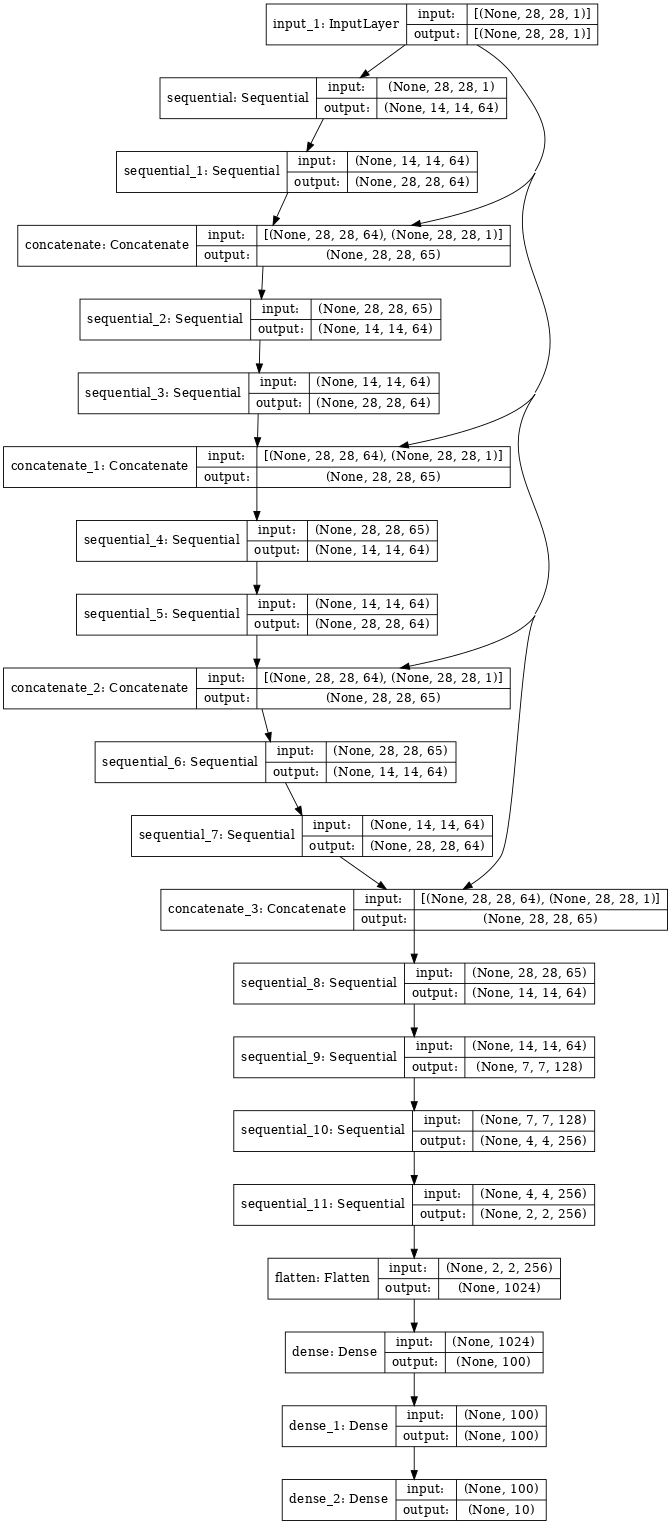

In [9]:
inputs = tf.keras.layers.Input(shape=[28, 28, 1])

# part find interest point and compute dist between each pixel like 
down = downsample(64, 4, apply_batchnorm=True)(inputs)
up = upsample(64, 4, apply_dropout=True)(down)
model = tf.keras.layers.Concatenate()([up, inputs])
down = downsample(64, 4, apply_batchnorm=True)(model)
up = upsample(64, 4, apply_dropout=True)(down)
model = tf.keras.layers.Concatenate()([up, inputs])
down = downsample(64, 4, apply_batchnorm=False)(model)
up = upsample(64, 4, apply_dropout=True)(down)
model = tf.keras.layers.Concatenate()([up, inputs])
down = downsample(64, 4, apply_batchnorm=False)(model)
up = upsample(64, 4, apply_dropout=True)(down)
model = tf.keras.layers.Concatenate()([up, inputs])

# part analising (classique: conv + relu)
down = downsample(64, 4, apply_batchnorm=False)(model)
down = downsample(128, 4, apply_batchnorm=False)(down)
down = downsample(256, 4, apply_batchnorm=False)(down)
down = downsample(256, 4, apply_batchnorm=False)(down)
model = tf.keras.layers.Flatten()(down)
model = tf.keras.layers.Dense(100)(model)
model = tf.keras.layers.Dense(100)(model)
out = tf.keras.layers.Dense(10)(model) #,activation="softmax"

model = tf.keras.Model(inputs=inputs, outputs=out)
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [10]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

model.compile(
    optimizer=optimizer,
    loss=loss_object,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(
    ds_train,
    epochs=4,
    callbacks=[callback]
)

Epoch 1/4


2022-08-20 12:38:27.602772: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


329/329 [==============================] - 381s 1s/step - loss: 0.2770 - sparse_categorical_accuracy: 0.9114
Epoch 2/4
329/329 [==============================] - 379s 1s/step - loss: 0.0890 - sparse_categorical_accuracy: 0.9729
Epoch 3/4
329/329 [==============================] - 379s 1s/step - loss: 0.0703 - sparse_categorical_accuracy: 0.9787
Epoch 4/4
329/329 [==============================] - 378s 1s/step - loss: 0.0581 - sparse_categorical_accuracy: 0.9829


In [11]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD()

def scheduler(epoch, lr):
  return lr * tf.math.exp(-0.1)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

model.compile(
    optimizer=optimizer,
    loss=loss_object,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    
)

model.fit(
    ds_train,
    epochs=4,
    callbacks=[callback]
)

Epoch 1/4
329/329 [==============================] - 380s 1s/step - loss: 0.0350 - sparse_categorical_accuracy: 0.9891
Epoch 2/4
329/329 [==============================] - 378s 1s/step - loss: 0.0260 - sparse_categorical_accuracy: 0.9919
Epoch 3/4
329/329 [==============================] - 378s 1s/step - loss: 0.0234 - sparse_categorical_accuracy: 0.9925
Epoch 4/4
329/329 [==============================] - 380s 1s/step - loss: 0.0219 - sparse_categorical_accuracy: 0.9929


In [12]:
predict = model.predict(x_test)

In [13]:
result = list(tf.math.argmax(predict, axis=1).numpy())
list_id = list(range(1, predict.shape[0] +1, 1))

submission = pd.DataFrame(list_id, columns=["ImageId"])
submission["Label"] = result

In [14]:
submission.to_csv("submission.csv", index=False)